In [1]:
import torch 
from torch.utils import data # 获取迭代数据
from torch.autograd import Variable # 获取变量
import torchvision
from torchvision.datasets import mnist # 获取数据集
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from pytorchtools import EarlyStopping
scaler = MinMaxScaler(feature_range=(0, 1))
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers, Sequential

In [2]:
# # 数据集的预处理
# data_tf = torchvision.transforms.Compose(
#     [
#         torchvision.transforms.ToTensor(),
#         torchvision.transforms.Normalize([0.5],[0.5])
#     ]
# )

# data_path = r'C:\Users\16526\Desktop\dataset'
# # 获取数据集
# train_data = mnist.MNIST(data_path,train=True,transform=data_tf,download=False)
# test_data = mnist.MNIST(data_path,train=False,transform=data_tf,download=False)

In [3]:
all_data = pd.read_csv(r"C:\Code\Python\PycharmProjects\数据分析\数据分析\shuffle.csv",index_col=0)
va = int(len(all_data)*0.7)
train_data = all_data[0:va]
test_data = all_data[va:]

In [4]:
max_value = max(train_data.max().values)
min_value = min(train_data.min().values)
ch = max_value - min_value

In [5]:
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))
train_data_normalized = train_data_normalized.reshape(-1,337)
train_X = train_data_normalized[:,0:-1].reshape(-1,1,336)
train_Y = train_data_normalized[:,-1]
train_X.shape

(1309, 1, 336)

In [6]:
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))
test_data_normalized = test_data_normalized.reshape(-1,337)
test_X = test_data_normalized[:,0:-1].reshape(-1,1,336)
test_Y = test_data_normalized[:,-1]

In [7]:
# dataset = tf.data.Dataset.from_tensor_slices((train_data_df_values, target.values))

In [8]:
class DeepAR(tf.keras.models.Model):
    """
    DeepAR 模型
    """
    def __init__(self, lstm_units):
        super().__init__()
        # 注意，文章中使用了多层的 LSTM 网络，为了简单起见，本 demo 只使用一层
        self.lstm = tf.keras.layers.LSTM(lstm_units, return_sequences=True, return_state=True)
        self.dense_mu = tf.keras.layers.Dense(1)
        self.dense_sigma = tf.keras.layers.Dense(1, activation='softplus')

    def call(self, inputs, initial_state=None):
        outputs, state_h, state_c = self.lstm(inputs, initial_state=initial_state)

        mu = self.dense_mu(outputs)
        sigma = self.dense_sigma(outputs)
        state = [state_h, state_c]

        return [mu, sigma, state]

def log_gaussian_loss(mu, sigma, y_true):
    """
    Gaussian 损失函数
    """
    return -tf.reduce_sum(tfp.distributions.Normal(loc=mu, scale=sigma).log_prob(y_true))

In [9]:
LSTM_UNITS = 14
EPOCHS = 100

# 实例化模型
model = DeepAR(LSTM_UNITS)

# 指定优化器
optimizer = tf.keras.optimizers.Adam(0.01)

# 使用 RMSE 衡量误差
rmse = tf.keras.metrics.MeanSquaredError()

# # 定义训练步
# def train_step(x, y):

# 训练
for epoch in range(EPOCHS):
    x = train_X
    y = train_Y
    with tf.GradientTape() as tape:
        mu, sigma, _ = model(x)
        loss = log_gaussian_loss(mu, sigma, y)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    rmse(mu, y)
    print('Epoch %d, RMSE %.4f' % (epoch + 1, rmse.result()))
    rmse.reset_states()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, RMSE 0.0366
Epoch 2, RMSE 0.1885
Epoch 3, RMSE 0.0521
Epoch 4, RMSE 0.1848
Epoch 5, RMSE 0.1523
Epoch 6, RMSE 0.1031
Epoch 7, RMSE 0.0726
Epoch 8, RMSE 0.0542
Epoch 9, RMSE 0.0414
Epoch 10, RMSE 0.0321
Epoch 11, RMSE 0.0265
Epoch 12, RMSE 0.0253
Epoch 13, RMSE 0.0285
Epoch 14, RMSE 0.0346
Epoch 15, RMSE 0.0410
Epoch 16, RMSE 0.0454
Epoch 17, RMSE 0.0462
Epoch 18, RMSE 0.0434
Epoch 19, RMSE 0.0383
Epoch 20, RMSE 0.0327
Epoch 21, RMSE 0.0282
Epoch 22, RMSE 0.0256
Epoch 23, RMSE 0.0247
Epoch 24, R

In [10]:
model.save('path_to_saved_model', save_format='tf')
# Recreate the exact same model
new_model = keras.models.load_model('path_to_saved_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: path_to_saved_model\assets


In [11]:
mu, sigma, _  = new_model(tf.constant(test_X))
loss = log_gaussian_loss(mu, sigma, test_Y)
rmse(test_Y, mu)
rmse.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.021456376>

In [12]:
def rereal(list_temp, min_value, max_value):
    arr = []
    for dat in list_temp:
        temp = dat*(max_value-min_value) + min_value
        arr.append(temp)
    return arr

In [13]:
num = len(test_Y)

In [14]:
outputs = mu.numpy().reshape(num)
y_pred_temp = outputs
tru_temp = test_Y.reshape(num)

In [15]:
MSE = 0
for i in range(num):
    MSE += (y_pred_temp[i] - tru_temp[i])**2
MSE /= num
MSE

0.021400608811286664

In [16]:
predict = rereal(y_pred_temp,min_value,max_value)
truth =  rereal(tru_temp,min_value,max_value)

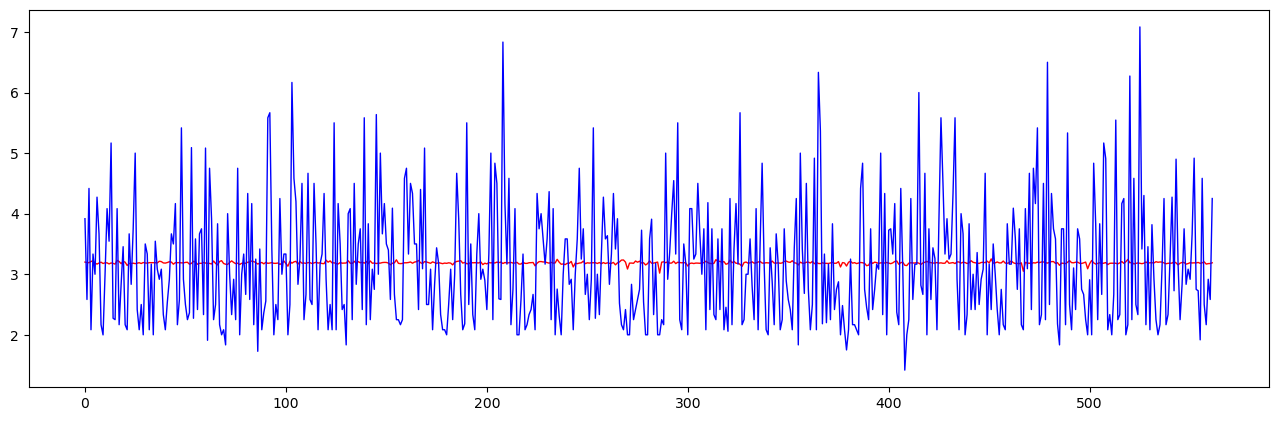

In [17]:
# 还原归一化
plt.figure(figsize=(16,5), dpi=100)
plt.plot(range(num), predict, c='red', lw='1')
plt.plot(range(num), truth, c='blue', lw='1')

In [18]:
# 求真实值与预测值的MSE
MSE = 0
for i in range(num):
    MSE += (predict[i] - truth[i])**2
MSE /= num
MSE

1.0237913341236111

(0.0, 3.0)

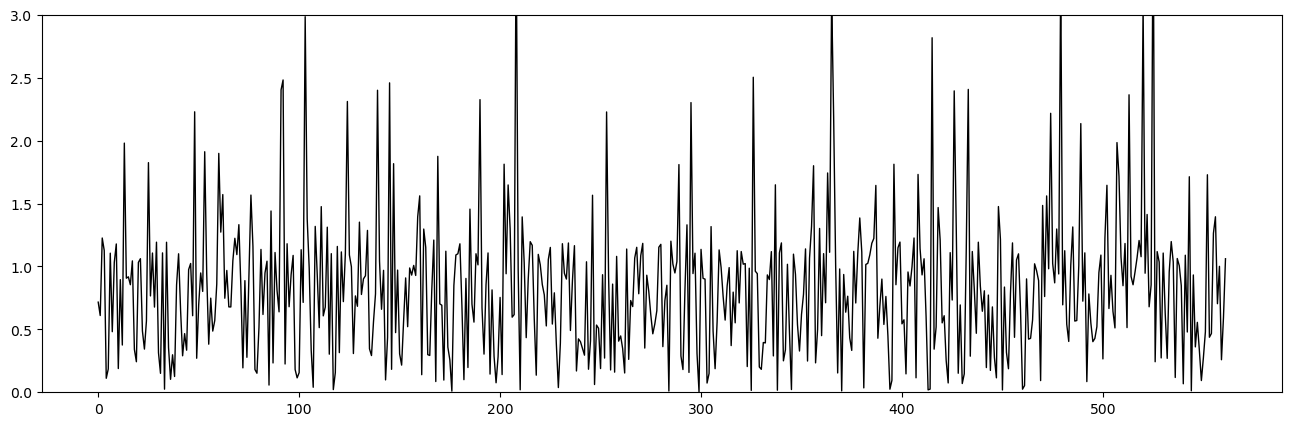

In [19]:
# 求真实值与预测值的误差值
errors = []
for i in range(num):
    error = abs(truth[i] - predict[i])
    errors.append(error)
plt.figure(figsize=(16,5), dpi=100)
plt.plot(range(num), errors, c='black', lw='1')
plt.ylim(0,3)

(0.0, 70.0)

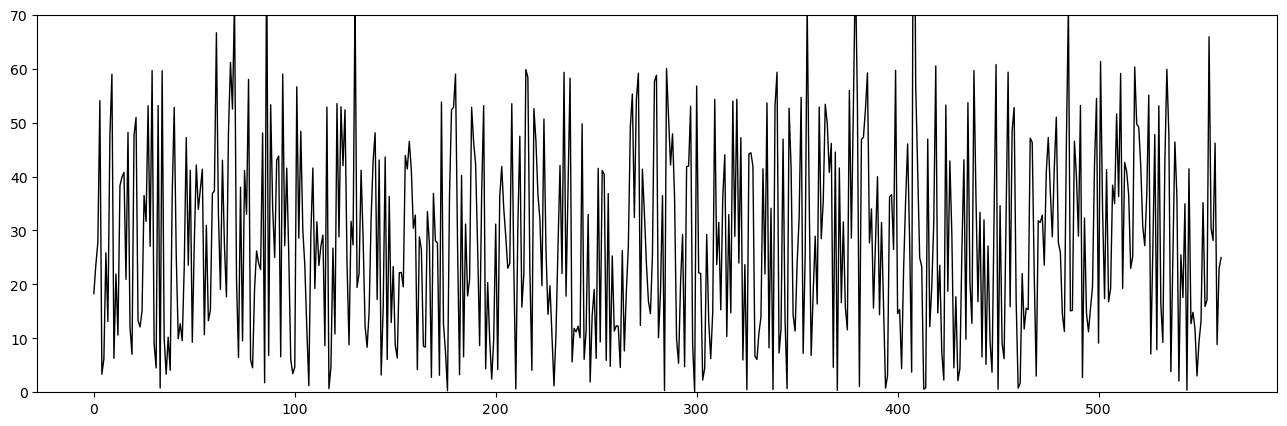

In [20]:
# 求真实值与预测值的误差值占原真实值的百分比
errors_p = []
for i in range(num):
    error = ((abs(truth[i] - predict[i]))/truth[i])*100
    errors_p.append(error)
plt.figure(figsize=(16,5), dpi=100)
plt.plot(range(num), errors_p, c='black', lw='1')
plt.ylim(0,70)

In [21]:
from numpy import mean
mean(errors_p)

28.21117329304035